In [23]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from scipy import optimize as opt
import Sequence_Analysis_Routines as sar

In [24]:
project_dir = 'D:/Project_Data/Project_3'
output_dir = project_dir + '/Output/Close_Species'
non_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Non_CDS'
tb_species = 'GCF_000195955.2'

In [25]:
num_states = 2
observation_length = 400

In [26]:
transition_probabilities = np.array([[0.9,0.1],[0.1,0.9]])
initial_state_probabilities = np.array([0.5, 0.5])
emission_probabilities = np.array([[0.9, 0.05, 0.01, 0.04],[0.1, 0.1, 0.1, 0.7]])
print(emission_probabilities[0])

[0.9  0.05 0.01 0.04]


In [27]:
states = np.zeros(observation_length, dtype='int16')
emissions = np.zeros(observation_length, dtype='int16')
observation_probabilities = np.zeros((num_states, observation_length))
states[0] = np.where(np.random.default_rng().multinomial(1, initial_state_probabilities, size=None) == 1)[0][0]
emissions[0] = np.where(np.random.default_rng().multinomial(1, emission_probabilities[states[0]], size=None) == 1)[0][0]
for i in range(1, observation_length):
    states[i] = np.where(np.random.default_rng().multinomial(1, transition_probabilities[states[i-1],:], size=None) == 1)[0][0]
    emissions[i] = np.where(np.random.default_rng().multinomial(1, emission_probabilities[states[i]], size=None) == 1)[0][0]
for i in range(observation_length):
    for j in range(num_states):
        observation_probabilities[j, i] =  emission_probabilities[j, emissions[i]]


In [28]:
class HMM:
    def __init__(self, initial_state_probabilities, transition_probabilities, observation_probabilities, termination = False):
        self.initial_state_probabilities = initial_state_probabilities
        self.transition_probabilities = transition_probabilities
        self.observation_probabilities = observation_probabilities
        self.num_states = observation_probabilities.shape[0]
        self.observation_length = observation_probabilities.shape[1]
        self.viterbi_path = np.zeros(self.observation_length, dtype='int16')
        self.viterbi_probability = 0
    
    def viterbi(self):
        max_probs = np.zeros((self.num_states, self.observation_length))
        pointers = np.zeros((self.num_states, self.observation_length), dtype='int16')
        for s in range(self.num_states):
            max_probs[s, 0] = math.log(self.initial_state_probabilities[s]) + math.log(self.observation_probabilities[s, 0])
        for i in range(1, self.observation_length):
            for t in range(self.num_states):
                max_state = 0
                max_val = -np.inf
                for s in range(self.num_states):
                    temp = max_probs[s, i-1] + math.log(self.transition_probabilities[s, t]) + math.log(self.observation_probabilities[t, i])
                    if temp > max_val:
                        max_state = s
                        max_val = temp
                max_probs[t, i] = max_val
                pointers[t, i] = max_state
        max_state = 0
        max_val = -np.inf
        for t in range(self.num_states):
            if max_probs[t, self.observation_length - 1] > max_val:
                max_state = t
                max_val = max_probs[t, self.observation_length - 1]
        self.viterbi_log_probability = max_val

        #  Traceback
        for i in reversed(range(self.observation_length)):
            self.viterbi_path[i] = max_state
            max_state = pointers[max_state, i]

In [29]:
def fit_hmm(trans_prob):
    transition_probabilities = np.array([[1-trans_prob[0],trans_prob[0]],[trans_prob[1],1-trans_prob[1]]])
    trial_hmm = HMM(initial_state_probabilities, transition_probabilities, observation_probabilities)
    trial_hmm.viterbi()
    return trial_hmm.viterbi_log_probability * -1

In [8]:
res = opt.minimize(fit_hmm, (0.5, 0.5), method = 'Nelder-Mead', bounds = ((0.01,0.99),(0.01,0.99)))
print(res.x)

[0.06912722 0.0616276 ]


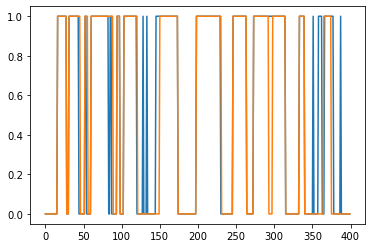

In [9]:
trans_prob = res.x
transition_probabilities = np.array([[1-trans_prob[0],trans_prob[0]],[trans_prob[1],1-trans_prob[1]]])
trial_hmm = HMM(initial_state_probabilities, transition_probabilities, observation_probabilities)
trial_hmm.viterbi()
fit_hmm(res.x)
plt.plot(states);
plt.plot(trial_hmm.viterbi_path)

In [30]:
def mutation_probs(rate_0, rate_1, alignment_list):
    align_list =  alignment_list
    len_align_list = len(alignment_list[0])
    num_sequences = len(alignment_list)
    symbols = ['A','C','G','T']
    observation_probs =  np.zeros((2, len_align_list))
    pseudo_counts = [0.01, 0.01, 0.01, 0.01]
    for i in range(len_align_list):
        temp =  [x[i] for x in alignment_list]
        for j, s in enumerate(symbols):
            if 1==2:
                pass
                #i <= 50 or len_align_list - i < 50:
                #observation_probs[0, i] = 0.01
                #observation_probs[1, i] = 0.99
            else:
                observation_probs[0, i] = observation_probs[0, i] + 0.25 * ((1-rate_0) ** (temp.count(s) + pseudo_counts[j])) * ((rate_0/3) ** (num_sequences - temp.count(s)))
                observation_probs[1, i] = observation_probs[1, i] + 0.25 * ((1-rate_1) ** (temp.count(s) + pseudo_counts[j])) * ((rate_1/3) ** (num_sequences - temp.count(s)))
    return observation_probs

In [31]:
file_ids = sar.list_files(non_cds_output_dir+'/')
ids = [int(i.split('.')[0]) for i in file_ids]

In [32]:
def fit_hmm_2(params):
    total_probability = 0
    group_ids = ids[200:250]
    #group_ids = [1569, 1505, 1167]
    for group_id in group_ids:
        #group_id =    1569 #1505    #  1167
        alignment = sar.Alignment(non_cds_output_dir+'/'+str(group_id)+'.fasta', tb_species, 'NT')
        alignment.modify_sequence(consensus=1)
        align_list =  alignment.modified_sequence_list
        len_align_list = len(align_list[0])
        non_cds = [x[50:len_align_list - 50] for x in align_list]
        if len(non_cds[0]) < 10:
            continue
        transition_probabilities = np.array([[1-params[0],params[0]],[params[1],1-params[1]]])
        observation_probabilities = mutation_probs(params[2], params[3], non_cds)
        trial_hmm = HMM(initial_state_probabilities, transition_probabilities, observation_probabilities)
        trial_hmm.viterbi()
        total_probability += trial_hmm.viterbi_log_probability * -1
    return total_probability

In [33]:
res = opt.minimize(fit_hmm_2, (0.01, 0.01, 0.3, 0.3), method = 'Nelder-Mead', bounds = ((0.00001,0.99999),(0.00001,0.99999),(0.00001,0.99999),(0.00001,0.99999)))
print(res.x)

[0.06445364 0.05997143 0.98837536 0.12248842]


-2109.537694830176


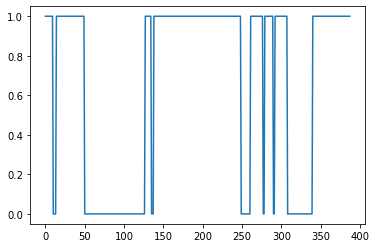

In [34]:
trans_prob = res.x
transition_probabilities = np.array([[1-trans_prob[0],trans_prob[0]],[trans_prob[1],1-trans_prob[1]]])
group_id =   1167 #1569 #1505    #  1167
alignment = sar.Alignment(non_cds_output_dir+'/'+str(group_id)+'.fasta', tb_species, 'NT')
alignment.modify_sequence(consensus=1)
alignment.calculate_entropies(mvave_len = 10)
align_list =  alignment.modified_sequence_list
len_align_list = len(align_list[0])
non_cds = [x[0:len_align_list - 0] for x in align_list]
observation_probabilities = mutation_probs(trans_prob[2], trans_prob[3], non_cds)
trial_hmm = HMM(initial_state_probabilities, transition_probabilities, observation_probabilities)
trial_hmm.viterbi()
print(trial_hmm.viterbi_log_probability)
plt.plot(trial_hmm.viterbi_path);

In [39]:
for i in range(10):
    alphabet = ['A','C','G','T']
    states = alphabet[np.where(np.random.default_rng().multinomial(1, np.array([0.25, 0.25, 0.25, 0.25]), size=None) == 1)[0][0]]
    print(states)

A
A
A
C
A
T
C
T
G
A
